# Image caption

### Our thinking
> About the model structure

* Usually , People attempt this task with CNN + RNN. For example, a Resnet(residual CNN) backbone to read an image, and a LSTM (gated RNN) layer to decipher the feature into words. Most of the models tried this **encoder + decoder** approach.

* Then comes the transformer, many papers have tried to use Transformer's mighty sequence analyze power to replace the RNN part.

* Since ```ViT``` model is slowly creaping up all sorts of computer vision leaderboard, it's a good time to use a full transformer network for the Image Caption job, which sadly has already been studied in the paper [CPTR: Full Transformer Network for Image Caption (Liu et. al)](https://arxiv.org/pdf/2101.10804.pdf), written only 9 months ahead of this notebook. But the model's detail is not the same at all, besides, the basic idea of a purely transformer model.

* Here we use ViT as encoder, GPT2 as decoder, all pretrained.

* And I promise you this is the shortest form of the training notebook I've seen on this topic

Ray 2021.10.19


> We are using `fastai`, `unpackai`, and `transformers` for this problem set

In [1]:
!pip install -q unpackai==0.1.8.10
!pip install -qq fastai==2.5.2
!pip install -q transformers==4.11.3

## Imports

Everything!!!

In [2]:
from fastai.vision.all import *
from fastai.text.all import *
from unpackai.utils import *
from unpackai.nlp import *

In [3]:
from transformers import (
    AutoModelWithLMHead,
    AutoTokenizer,
    AutoModel,
    ViTFeatureExtractor,
    PreTrainedTokenizer,
    EncoderDecoderModel
    )

In [4]:
from unpackai.nlp import HFTextBlock

## Download dataset

We can download and unzip the data.

In [12]:
%%time
download_and_unpack("http://images.cocodataset.org/zips/val2014.zip", ".")

CPU times: user 49 s, sys: 38.2 s, total: 1min 27s
Wall time: 4min 53s


Path('.')

In [8]:
%%time
download_and_unpack("http://images.cocodataset.org/annotations/annotations_trainval2014.zip", ".")

CPU times: user 5.93 s, sys: 2.08 s, total: 8.01 s
Wall time: 9.6 s


Path('.')

After unzip, this is how much types of annotation we have.

In [11]:
ls("annotations")[["Name", "Path", "Last_Modif", "Friendly_Size"]]

,Name,Path,Last_Modif,Friendly_Size
2,captions_train2014.json,annotations/captions_train2014.json,2021-10-25 15:39:54.086041,63.69 MB
5,captions_val2014.json,annotations/captions_val2014.json,2021-10-25 15:39:54.391041,30.92 MB
0,instances_train2014.json,annotations/instances_train2014.json,2021-10-25 15:39:49.936047,317.15 MB
1,instances_val2014.json,annotations/instances_val2014.json,2021-10-25 15:39:51.728044,153.24 MB
3,person_keypoints_train2014.json,annotations/person_keypoints_train2014.json,2021-10-25 15:39:52.947043,162.82 MB
4,person_keypoints_val2014.json,annotations/person_keypoints_val2014.json,2021-10-25 15:39:53.690042,77.86 MB


... and this is part of the pictures

In [13]:
ls("val2014")[["Name", "Path", "Last_Modif", "Friendly_Size"]]

,Name,Path,Last_Modif,Friendly_Size
34581,COCO_val2014_000000000042.jpg,val2014/COCO_val2014_000000000042.jpg,2021-10-25 15:47:27.676422,208.31 KB
578,COCO_val2014_000000000073.jpg,val2014/COCO_val2014_000000000073.jpg,2021-10-25 15:46:38.540489,374.66 KB
31560,COCO_val2014_000000000074.jpg,val2014/COCO_val2014_000000000074.jpg,2021-10-25 15:47:56.190383,172.02 KB
4189,COCO_val2014_000000000133.jpg,val2014/COCO_val2014_000000000133.jpg,2021-10-25 15:47:03.359455,159.77 KB
22111,COCO_val2014_000000000136.jpg,val2014/COCO_val2014_000000000136.jpg,2021-10-25 15:46:55.272466,102.62 KB
...,...,...,...,...
6600,COCO_val2014_000000581886.jpg,val2014/COCO_val2014_000000581886.jpg,2021-10-25 15:46:54.770467,92.16 KB
600,COCO_val2014_000000581887.jpg,val2014/COCO_val2014_000000581887.jpg,2021-10-25 15:46:00.963540,105.04 KB
2355,COCO_val2014_000000581899.jpg,val2014/COCO_val2014_000000581899.jpg,2021-10-25 15:46:04.669535,212.90 KB
30474,COCO_val2014_000000581913.jpg,val2014/COCO_val2014_000000581913.jpg,2021-10-25 15:48:25.071344,135.18 KB


## Explorative Data Analysis

Path to image directory

In [14]:
path_val = Path("./val2014")
anno = Path("annotations/captions_val2014.json").read_json()

In [15]:
len(anno['annotations'])

202654

In [16]:
image_df = pd.DataFrame(anno['images'])
anno_df = pd.DataFrame(anno['annotations'])

In [17]:
image_df.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,COCO_val2014_000000391895.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg,391895
1,4,COCO_val2014_000000522418.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000522418.jpg,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg,522418
2,3,COCO_val2014_000000184613.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000184613.jpg,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg,184613
3,3,COCO_val2014_000000318219.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000318219.jpg,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_813ea2751b_z.jpg,318219
4,3,COCO_val2014_000000554625.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000554625.jpg,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_8f59d8a473_z.jpg,554625


In [18]:
anno_df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wheel.
1,179765,38,A black Honda motorcycle parked in front of a garage.
2,322141,49,A room with blue walls and a white sink and door.
3,16977,89,A car that seems to be parked illegally behind a legally parked car
4,106140,98,A large passenger airplane flying through the air.


In [21]:
file_name_2_id = dict(image_df[["file_name","id",]].values)
id_2_caption = dict(anno_df[["image_id","caption"]].values)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In most cases, the **```get_y```**function may differ by datasets' annotation's format.

As long as you can return a string of text, according to the image path input, it will be fine

In [20]:
def get_y(path: Path):
    # file name of the iamge path
    file_name = path.name
    # get the caption according to image file name
    idx = file_name_2_id.get(file_name)
    return f": {id_2_caption.get(idx)}"

In [23]:
INPUT_MEAN = [.5,.5,.5]
INPUT_STD = [.5,.5,.5]

The fastai datablock

In [24]:
dblock = DataBlock(blocks = (
    ImageBlock,
    HFTextBlock(tokenizer,max_length=32,padding="max_length",truncation=True)),
                   get_items = get_image_files,
                   item_tfms = Resize(224),
                   batch_tfms=[
                               IntToFloatTensor(),
                               Normalize.from_stats(INPUT_MEAN,INPUT_STD),],
                   get_y     = get_y,
                   splitter  = RandomSplitter(),
                   )

To generate text, we use the transformer decoder for the task, which require the generated target as a part of x

In [25]:
def batch_x_merge_y(batch, b):
    x, y = batch
    return (x, y), y

dblock.dls_kwargs['retain'] = batch_x_merge_y

In [26]:
dsets = dblock.datasets(path_val)
x, y = dsets.train[0]

Display a line of data

text being:	: Plate containing fish, green beans and other food. 


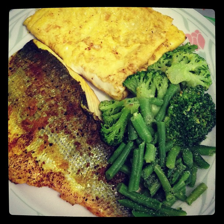

In [ ]:
print(f"text being:\t{y}")
x.resize((224,224))

Create dataloaders

In [27]:
dls = dblock.dataloaders(path_val, bs=16)

In [28]:
batch = dls.one_batch()

This (x,y), y format is very unique for encoder-decoder model.

Where encoder will extract features from x(image)

And decoder use the **encoder output**+**prompt from previous tokens** to guess the next token

When we train the model, we guess the $n_{th}$ token by

$\hat{y_n}=EncoderDecoder(x,y_{[1:n]})$
Then we calculate the loss:
$L = CrossEntropy(\hat{y}, y)$,

Within this encoder_decoder model, this is what happens: $Feature=encoder(x), \hat{y_{n}}=decoder(Feature, y_{[1:n-1]})$

Hence (x,y), y from the dataloaders instead of usual x, y for other deep learning tasks

When we generate text after training, for inference, we input only x



In [29]:
(batch_img, batch_txt), batch_txt2 = batch

In [30]:
batch_img.shape, batch_txt.shape, batch_txt2.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 32]), torch.Size([16, 32]))

## Model

### Pretrained models

In [ ]:
# encoder focus on encoding the features from image
    # in thie case, we use a ViT model pretrained on imagenet classification task
encoder = AutoModel.from_pretrained('google/vit-base-patch16-224-in21k')

# decoder focus on decoding the image features to text sequence
    # here we use GPT2 as our decoder, a pretrained model good at generating text
decoder = AutoModelWithLMHead.from_pretrained("gpt2", add_cross_attention=True)
decoder.tokenizer = tokenizer

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:664: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.8.crossattention.c_proj.bias', 'h.2.crossattention.c_proj.bias', 'h.1.crossattention.q_attn.weight', 'h.1.crossattention.bias', 'h.2.crossattention.c_attn.weight', 'h.5.crossattention.c_proj.bias', 'h.10.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.4.crossattention.masked_bias', 'h.9.crossattention.q_attn.weight', 'h.6.crossattention.bias', 'h.3.crossattention.c_proj.weight', 'h.0.crossattention.c_proj.bias', 'h.11.crossattention.c_proj.weight', 'h.0.crossattention.bias', 'h.8.ln_cross_attn.weight', 'h.5.crossattention.q_attn.weight', 'h.11.crossattention.q_attn.weight', 'h.6.crossattention.c_proj.bias', 'h.9.crossattention.masked_bias', 'h.10.crossattention.c_proj.bias', 'h.9.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.3.crossattention.c_proj.bias', 'h.7.ln_cross_attn.weight', 'h.6.ln_cross_attn.weight', 'h.3.ln_cross_at

### Caption Model

In [ ]:
class Caption(nn.Module):
    """
    The caption model is created by
        combining decoder and encoder
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        """
        
        - encoder: The encoder model that can extract image features
        - decoder: The decoder model that can generate text sequence
            - you have to set add_cross_attention
                to True when instantiate the model
        """
        super().__init__()
        self.encoder_decoder = EncoderDecoderModel(
            encoder=encoder,
            decoder=decoder,)
        
        # update generate documentation
        self.generate.__func__.__doc__ = f"""
        Generate text with image:
        - batch_img: a batch of image tensor
        - other generate kwargs please see following
        {self.encoder_decoder.decoder.generate.__doc__}"""
        
    def forward(self, inputs):
        x, input_ids = inputs
        # extract image feature with encoder
        # the extracted feature we call them: encoder_outputs
        encoder_outputs = self.encoder_decoder.encoder(x)
        
        # predict text sequence logits
        # with the encoder_outputs
        seq_out = self.encoder_decoder(
            encoder_outputs=encoder_outputs,
            # decoder_inputs is to help decoders learn better, 
            # decoder has mask that allow model to see
            # only the previous text tokens and encoder feature
            decoder_input_ids=input_ids,
            labels=input_ids,
            )
        return seq_out
    
    def generate(self, batch_img, **generate_kwargs):
        with torch.no_grad():
            # extract image features first
            encoder_outputs = self.encoder_decoder.encoder(pixel_values=batch_img)
            return self.encoder_decoder.decoder.tokenizer.batch_decode(
                # encoder_decoder has a 'generate' function we can use
                self.encoder_decoder.generate(
                    encoder_outputs=encoder_outputs,
                    **generate_kwargs), )

### Loss Function

The model output object contains ```logits``` and ```loss```

The loss result is already in the model output. So our loss function here is only to get the loss number.

Behind the scene, transformer calculated the loss using ```nn.CrossEntropyLoss```

In [ ]:
def use_output_loss(output, label):
    return output.loss

Since the output format, the original accuracy(which compares logits with label) won't work, let's redifine one

In [ ]:
def hf_accuracy(output, label):
    return (output.logits.argmax(-1)==label).float().mean()

## Training

Create the model with the pretrained sub-models: ```encoder``` and ```decoder```

In [ ]:
model = Caption(encoder, decoder)

In [ ]:
learn = Learner(dls, model, loss_func=use_output_loss, metrics=[hf_accuracy], )

In [ ]:
learn.fit(3)

epoch,train_loss,valid_loss,hf_accuracy,time
0,1.255161,1.259745,0.591427,1:02:29


epoch,train_loss,valid_loss,hf_accuracy,time
0,1.255161,1.259745,0.591427,1:02:29
1,1.168037,1.237680,0.591385,1:02:32
2,1.085814,1.249942,0.591404,1:02:27


In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,hf_accuracy,time
0,1.028793,1.283893,0.591362,1:02:26


## See the result

In [ ]:
encoder = encoder.eval()

For the arguments of **generating text**, you can use the following as default

Or try to understand this very well written [blog post](https://huggingface.co/blog/how-to-generate) explaining what are the arguements exactly

In [ ]:
model.generate(batch_img[:1,...],
               top_p=.6, do_sample=True, # text generation startegy
               bos_token_id=tokenizer.vocab[':'],)[0].replace("<|endoftext|>","")

': a close up of a train that is on a train track'

Compare to the same batch of text label

In [ ]:
tokenizer.batch_decode(batch_txt)[0].replace("<|endoftext|>","")

': A high speed train pulls into a platform while people watch.'

Show image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


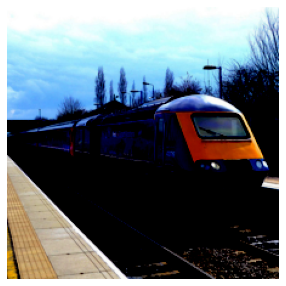

In [ ]:
batch_img[0,...].show()